<a href="https://colab.research.google.com/github/Derrc/Reinforcement-Learning/blob/main/colab/atari_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atari DQN (Currently on PONG environment)**

In [ ]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 879 kB 8.4 MB/s 
     |████████████████████████████████| 1.7 MB 12.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached libtorrent-2.0.7-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.0-py3-none-any.whl size=440868 sha256=d855d3ddfb78a5f63ed30493d39ca850d2b817850fa7a18dab42f19aa2465561
  Stored in directory: /root/.cache/pip/wheels/bf/c9/25/578470ae932b494c313dc22e6c57afff192140fb3cd5acf185
Successfully built AutoROM.accept-rom-license


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive

# mount google drive for saving checkpoints
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Initialize Environment**

In [ ]:
# ENVS
PONG = 'PongNoFrameskip-v4'
FREEWAY = 'FreewayNoFrameskip-v4'
SEAQUEST = 'SeaquestNoFrameskip-v4'

# initialize environment and apply gym wrappers
env = gym.make(PONG, render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(
    env = env,
    noop_max=30,
    frame_skip=4,
    screen_size=84,
    terminal_on_life_loss=False,
    grayscale_obs=True,
)
# retuns the 4 most recent observations (deque)
env = gym.wrappers.FrameStack(env, num_stack=4)

<ipython-input-4-37a56838bab2>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  frames = torchvision.utils.make_grid(torch.tensor(state).unsqueeze(1)).numpy()


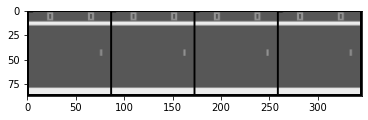

In [ ]:
# visualize observation space from env
state = env.reset()[0]
frames = torchvision.utils.make_grid(torch.tensor(state).unsqueeze(1)).numpy()
plt.imshow(np.transpose(frames, (1, 2, 0)))


# **Hyperparameters**

In [ ]:
# Action Offset
ACTION_OFFSET = 4

# Episodes
EPISODES = 10000
# Max Steps per Episode
MAX_STEPS = 1000
# Mini-Batch Size for Experience Replay
BATCH_SIZE = 32
# Size of Replay Buffer and Initial Buffer
BUFFER_INITIAL = 10000
BUFFER_SIZE = 100000
# Discount Factor
GAMMA = 0.99
# Learning Rate
LR = 1e-4
# Seed
SEED = 11
# Epsilon Decay
EPSILON_DECAY = 400
# Path to save model
PATH = '/content/gdrive/My Drive/RL/Atari/models/atari_dqn.pth'
# device to run model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# **Classes**

In [ ]:
# CNN network
class AtariCNN(nn.Module):
  def __init__(self, state_dim, action_dim):
      super().__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(state_dim, 16, kernel_size=8, stride=4),
          nn.ReLU(),
          nn.Conv2d(16, 32, kernel_size=4, stride=2),
          nn.ReLU(),
      )
      self.fc = nn.Sequential(
          nn.Linear(2592, 256),
          nn.ReLU(),
          nn.Linear(256, action_dim)
      )

  def forward(self, x):
      x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
      x = self.conv(x)
      x = torch.flatten(x, 1) # keep batch size
      x = self.fc(x)
      return x

  def get_action(self, actions, episode):
      epsilon = 0.01 + 0.99 * np.exp(-1 * episode / EPSILON_DECAY)
      if np.random.rand() < epsilon:
          return np.random.choice(len(actions))
    
      return np.argmax(actions.detach().cpu().numpy())

  # input state -> get action sampled from current policy and q_value
  def act(self, state, episode):
      state = np.expand_dims(state, 0)
      q_values = self.forward(state).squeeze(0)
      action = self.get_action(q_values, episode)
      return action


# experience replay buffer
class ReplayBuffer():
    def __init__(self, max_length):
        self.buffer = deque(maxlen=max_length)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done = zip(*experiences)
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), done

    def __len__(self):
        return len(self.buffer)

# **Helper Functions**

In [ ]:
# train from mini-batch of experiences
def train_off_experience(network, target_network, buffer, criterion, optim):
    state, action, reward, next_state, done = buffer.sample(BATCH_SIZE)
    action = torch.tensor(action, dtype=torch.long).to(DEVICE)
    reward = torch.tensor(reward, dtype=torch.float32).to(DEVICE)
    done = torch.tensor(done, dtype=torch.long).to(DEVICE)

    # get q values of actions taken
    q_values = network(state)
    q_value_from_action = torch.gather(q_values, 1, action.unsqueeze(1)).squeeze(1)

    # get best next q values: max(q_values) from target network
    next_q_values = target_network(next_state)
    next_q_value_from_action = torch.max(next_q_values, 1)[0]

    # compute loss and update parameters
    optim.zero_grad()
    td_target = reward + (1 - done) * GAMMA * next_q_value_from_action
    td_loss = criterion(q_value_from_action, td_target)
    td_loss.backward()
    optim.step()

# run a random policy through environment to collect states to calculate average Q-Values
def get_evaluation_states(env, episodes):
    evaluation_states = []
    for _ in range(episodes):
        state = env.reset()[0]
        for _ in range(1000):
            evaluation_states.append(state)
            action = env.action_space.sample()

            next_s, r, done, _, _ = env.step(action)

            state = next_s

            if done:
                break
    
    return evaluation_states


# compute the average Q-Value of states as an evaluation metric
def get_average_q_value(model, states):
    with torch.no_grad():
        q_values = model(np.array(states)).cpu()
    return torch.mean(q_values)


# train
def train(network, target_network, optim, criterion, buffer, current_episode):
    # load checkpoint
    if os.path.exists(PATH):
        network.load_state_dict(torch.load(PATH))
        target_network.load_state_dict(torch.load(PATH))

    network.train()
    # keep track of q-values in evaluation states
    evaluation_states = get_evaluation_states(env, 10)
    total_rewards = []
    total_q_values = []
    for episode in range(current_episode, EPISODES):
        state = env.reset(seed=SEED)[0]
        rewards = []
        # run trajectory through episode
        for _ in range(MAX_STEPS):
            action = network.act(state, episode)

            next_s, r, done, _, _ = env.step(action + ACTION_OFFSET)

            # add experience to replay buffer
            buffer.push(state, action, r, next_s, done)

            # sample from replay buffer if len(buffer) > BUFFER_INITIAL
            if len(buffer) > BUFFER_INITIAL:
                train_off_experience(network, target_network, buffer, criterion, optim)

            rewards.append(r)
            state = next_s
            
            if done:
                break

        # update target network every episode
        target_network.load_state_dict(network.state_dict())

        total_rewards.append(np.sum(rewards))
        total_q_values.append(get_average_q_value(network, evaluation_states))
        if episode % 10 == 0:
            plot(total_rewards, total_q_values, episode)
            # save checkpoint every 50 episodes
            torch.save(network.state_dict(), PATH)
    
    # return totals
    return total_rewards.cpu(), total_q_values.cpu()

# plot
def plot(total_rewards, total_q_values, episode):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f'Reward: {np.mean(total_rewards):.3f} at Episode {episode} Using DQN')
    plt.plot(total_rewards)
    plt.subplot(132)
    plt.title(f'Q-Value: {np.mean(total_q_values):.3f} at Episode {episode} Using DQN')
    plt.plot(total_q_values)
    plt.show()

# **Training**

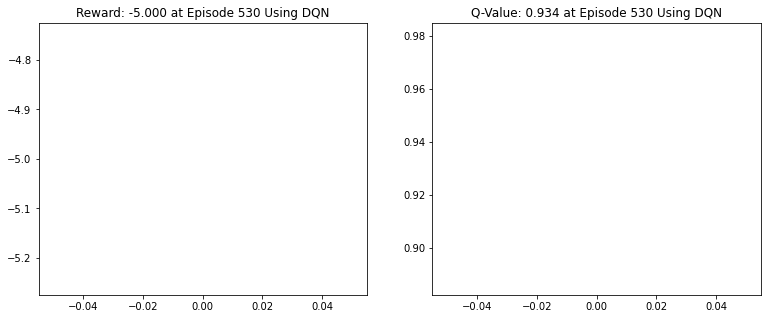

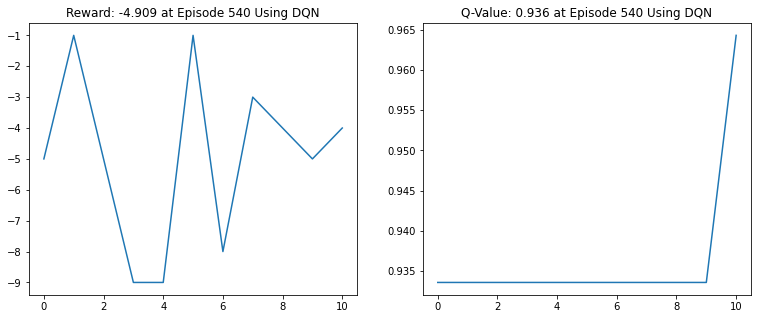

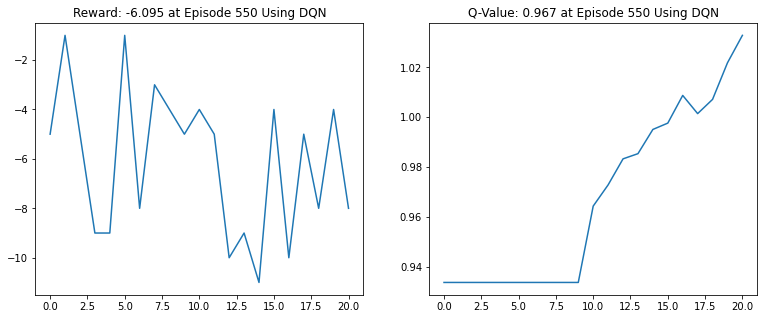

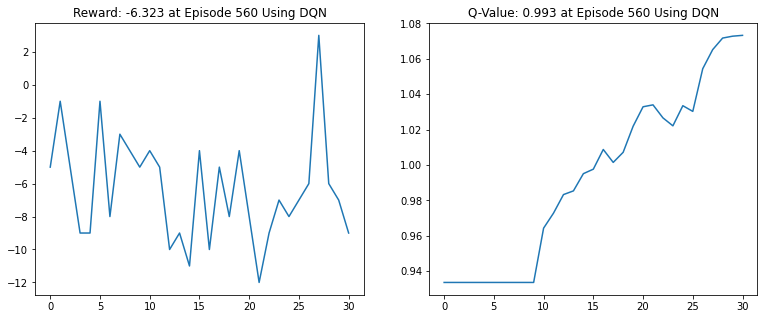

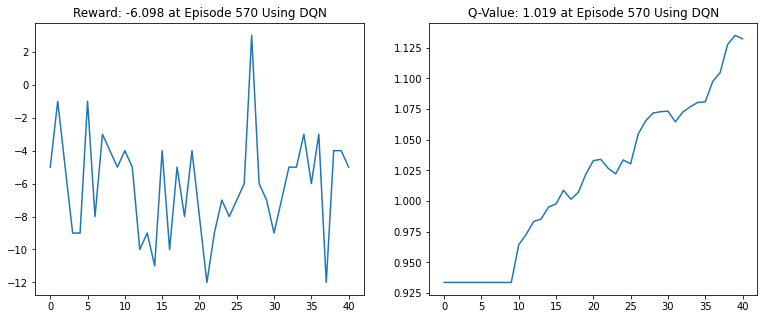

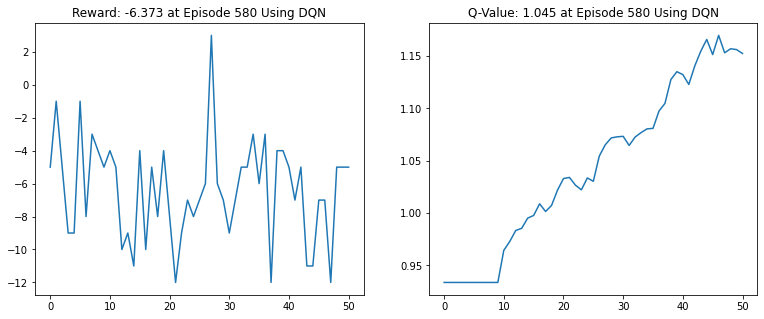

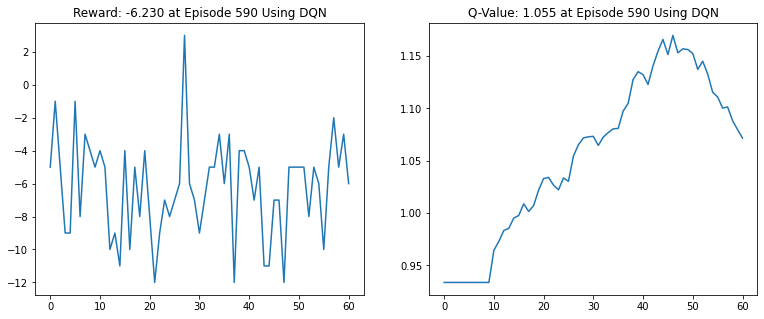

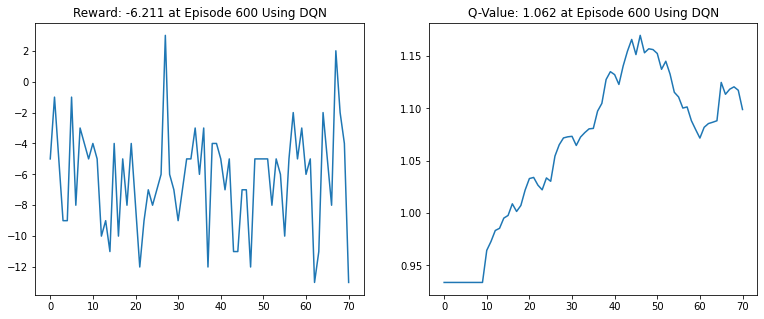

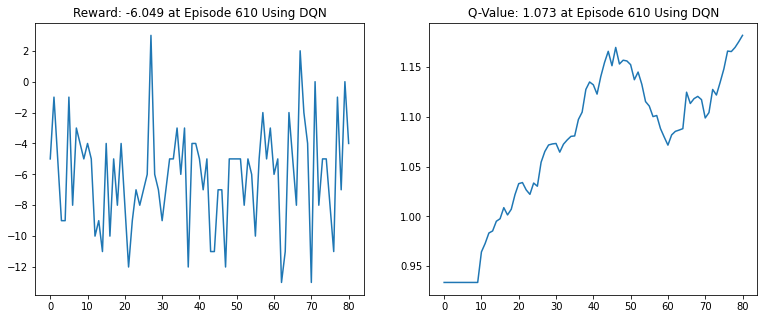

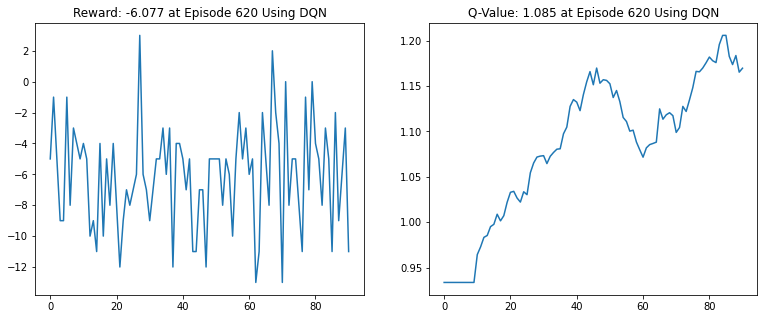

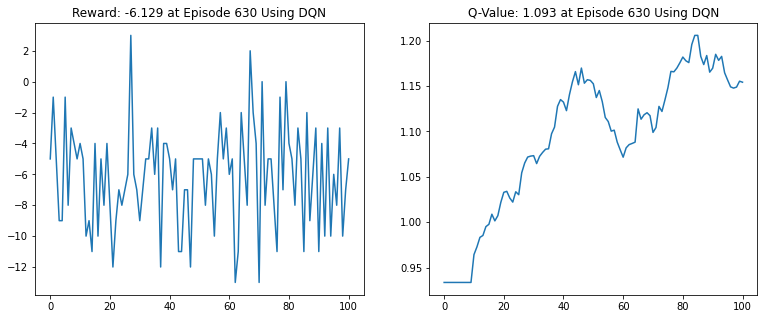

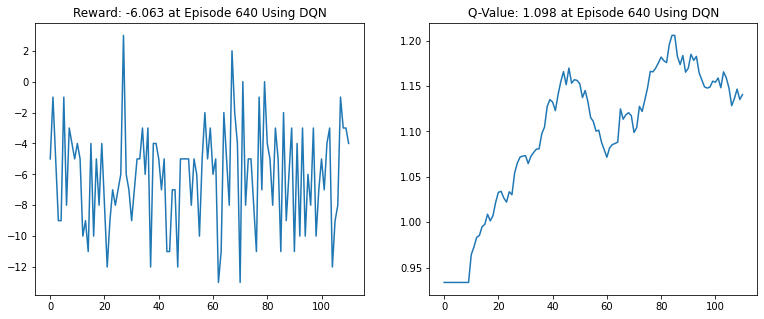

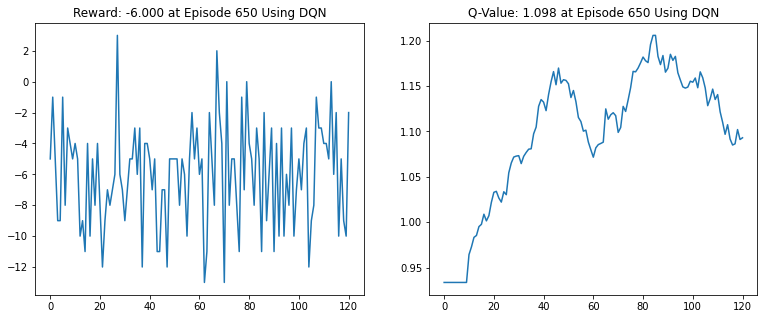

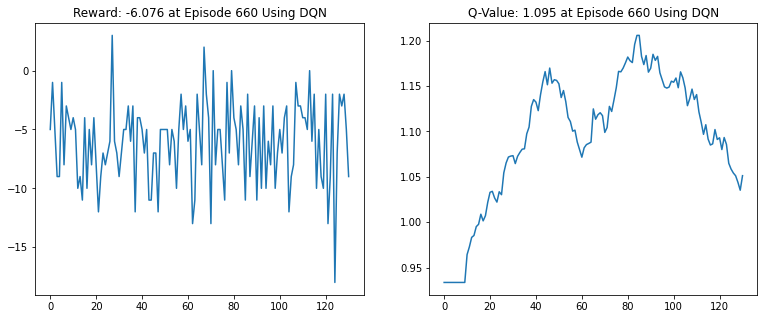

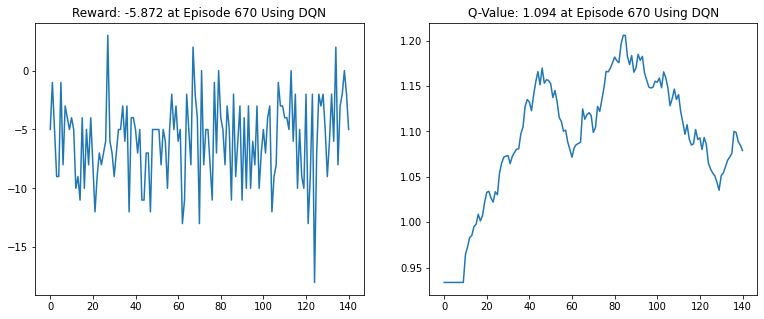

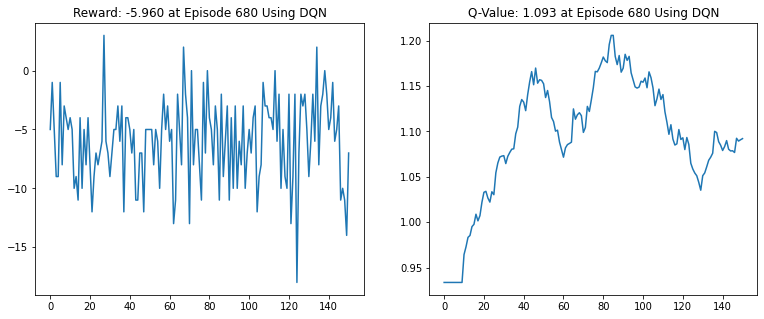

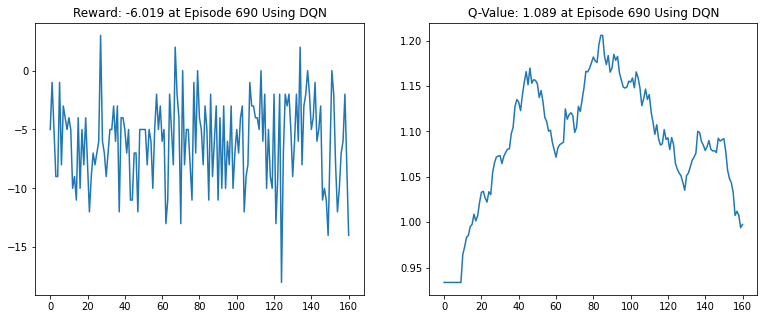

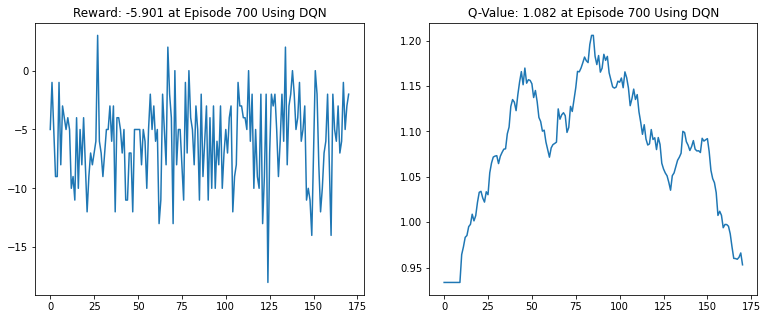

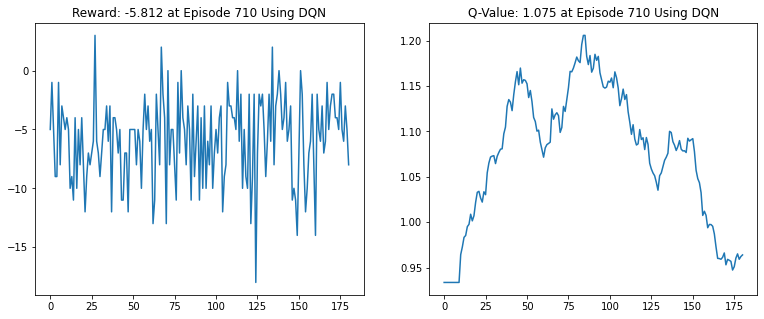

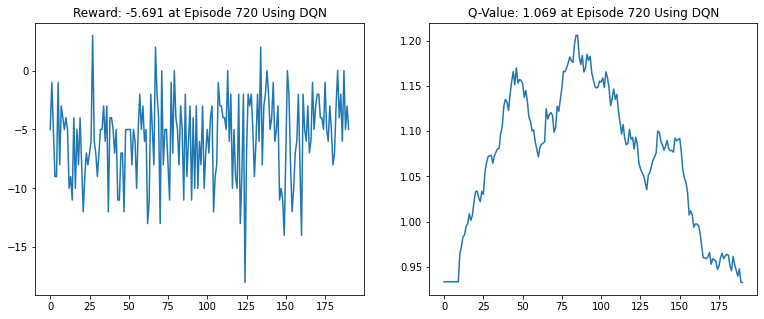

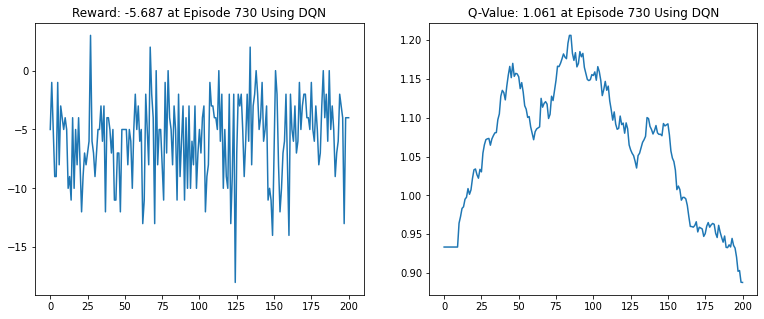

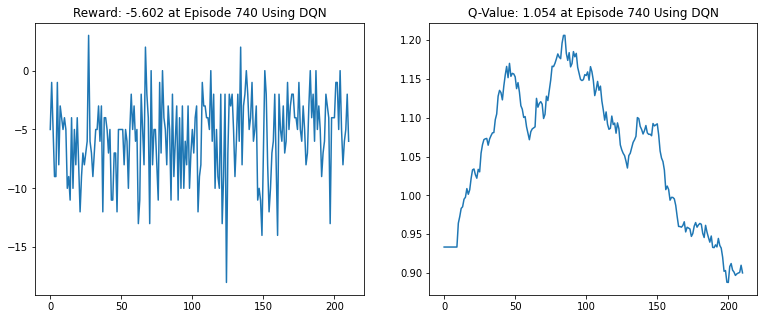

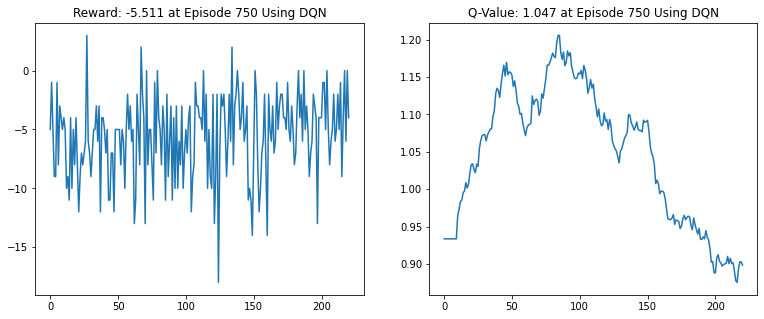

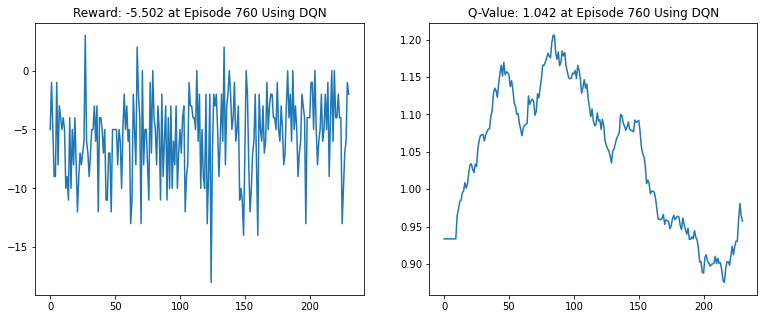

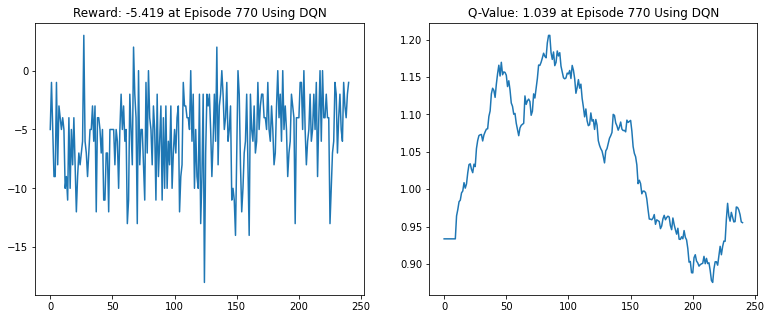

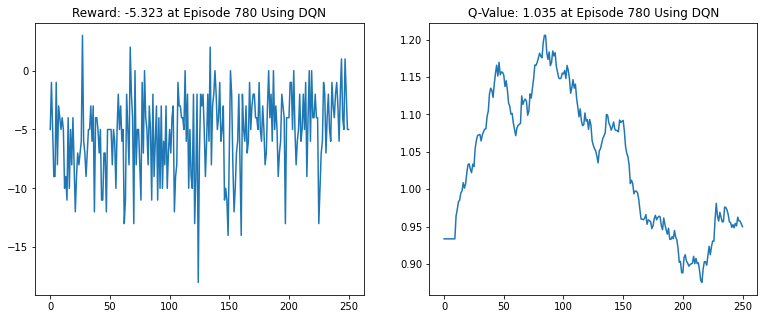

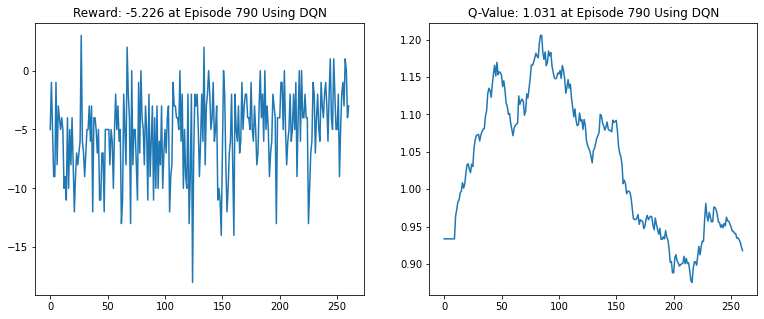

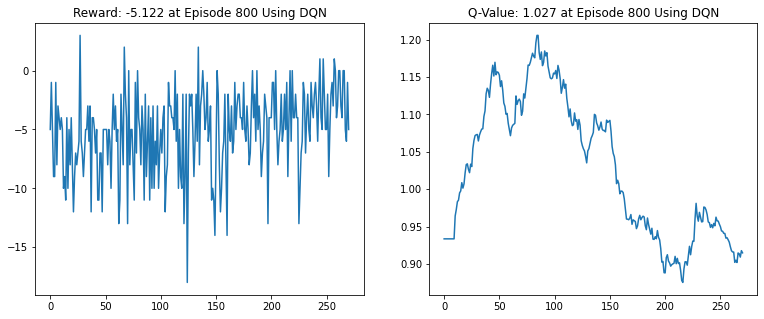

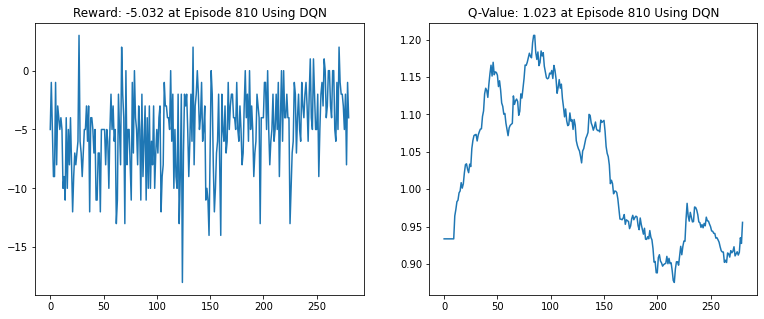

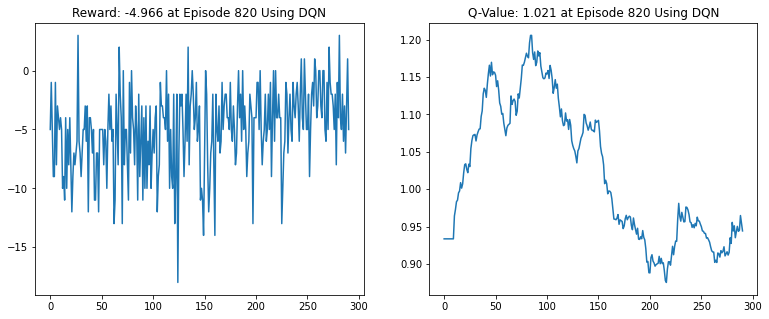

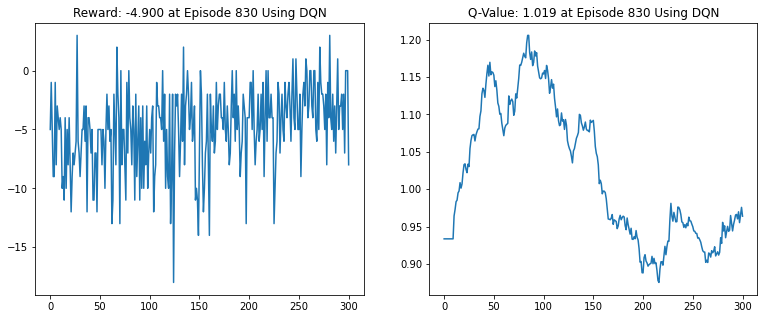

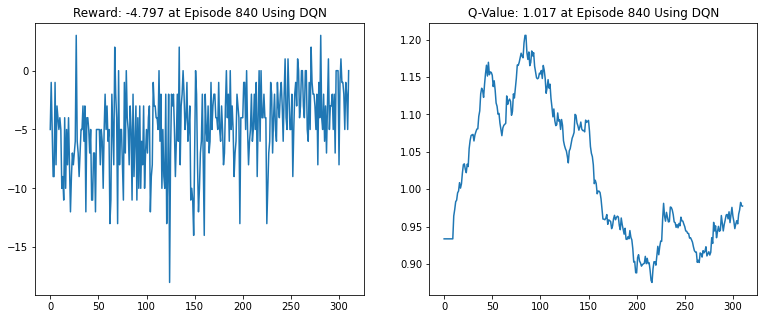

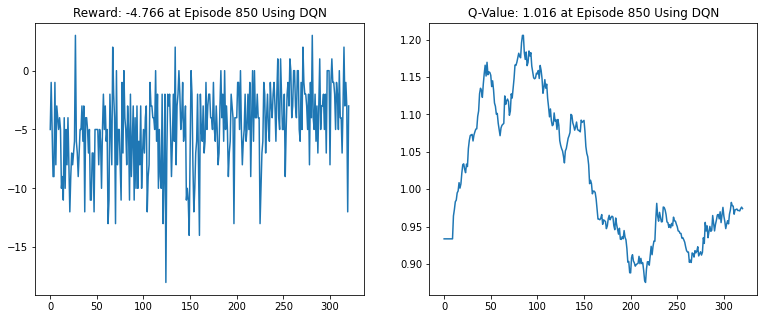

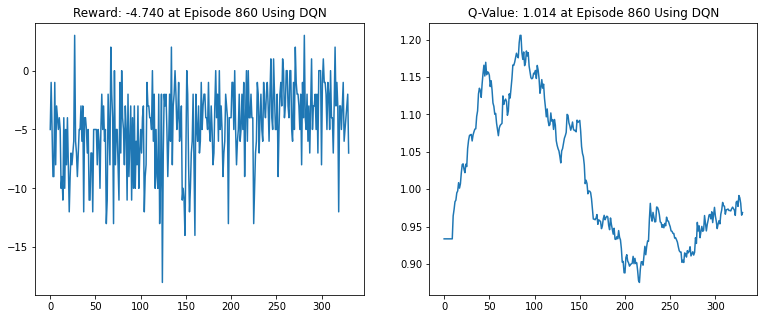

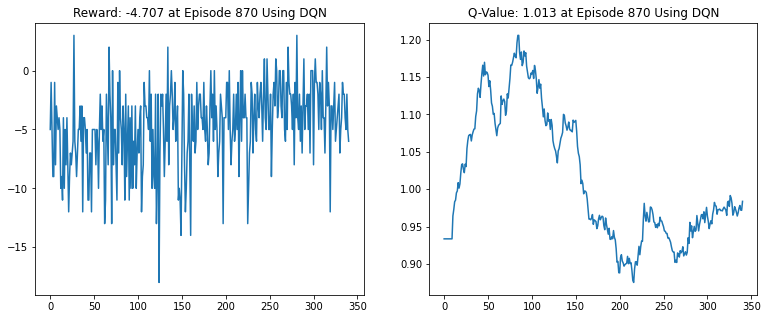

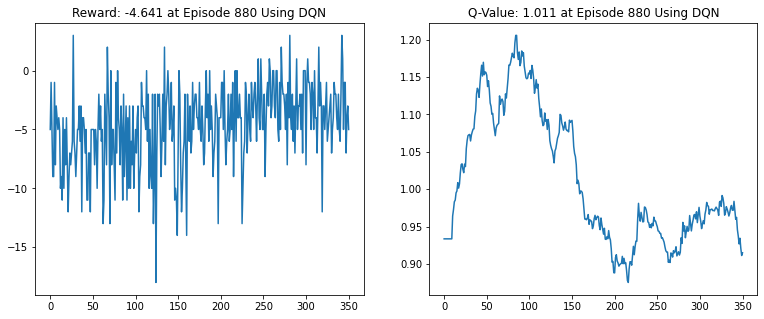

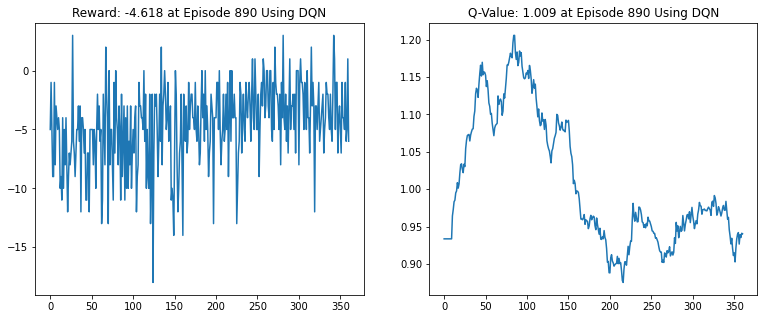

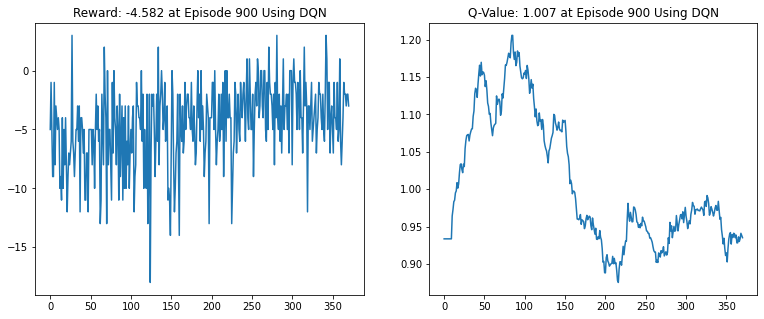

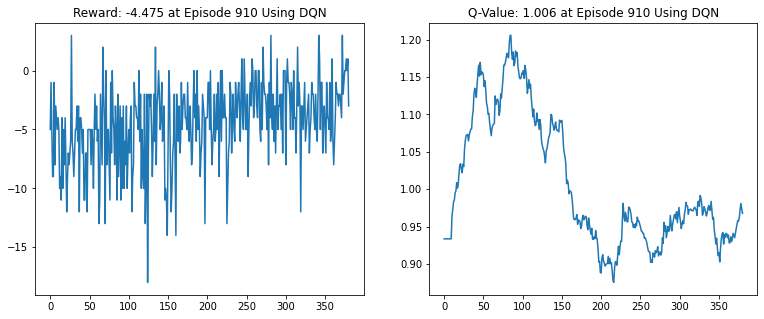

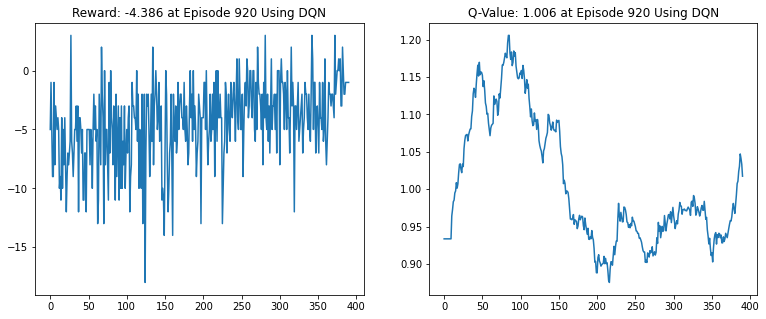

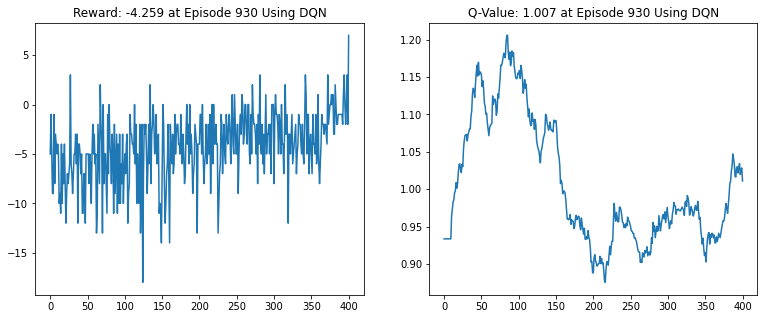

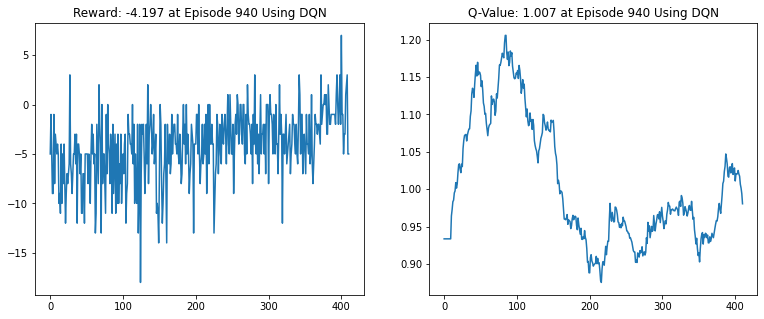

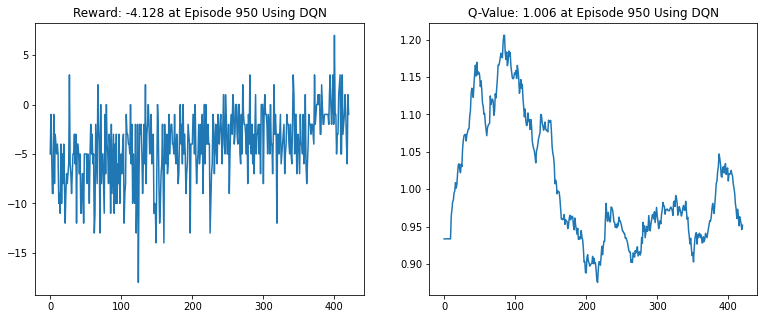

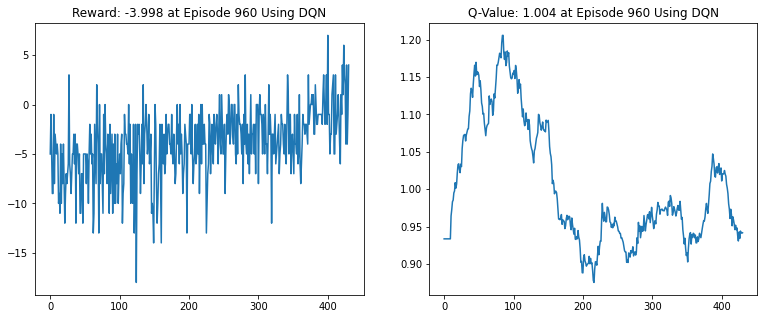

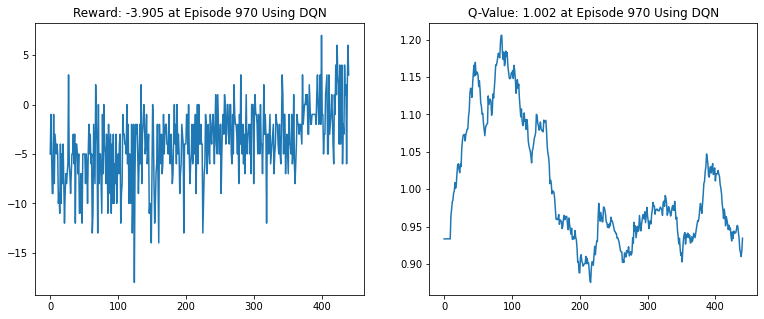

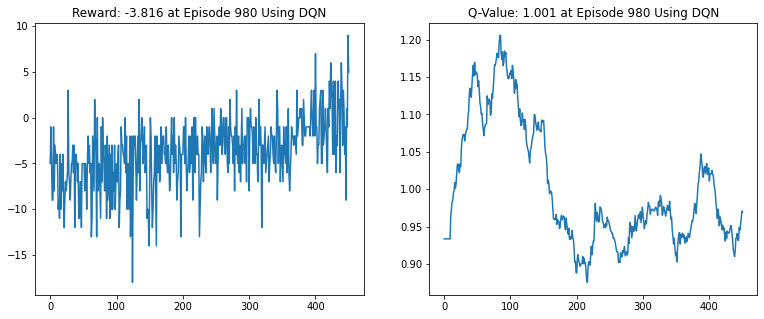

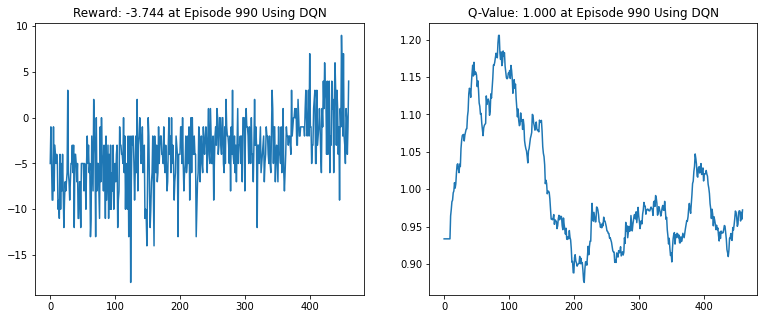

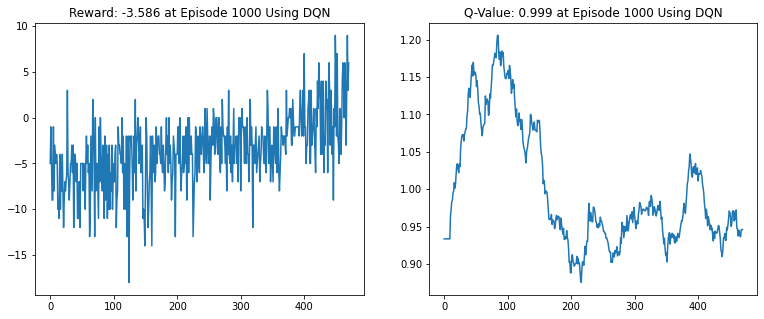

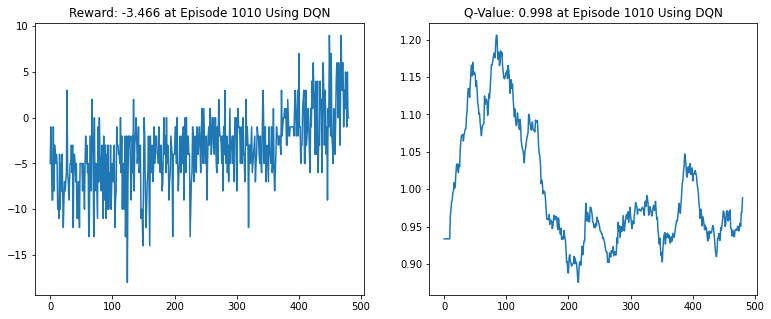

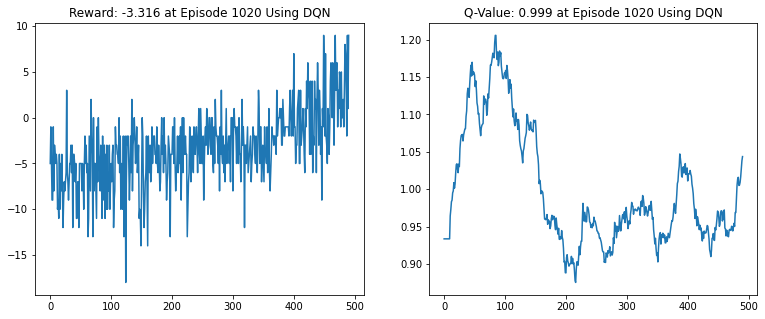

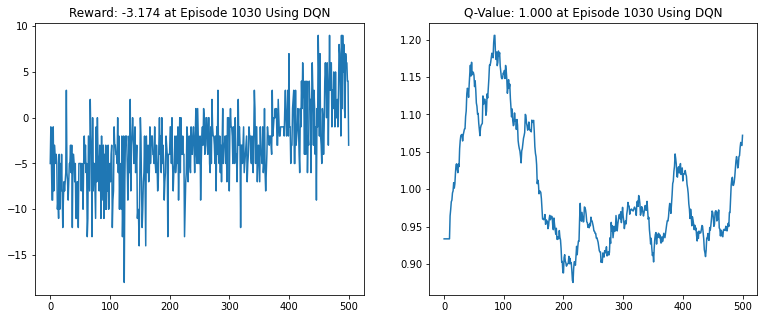

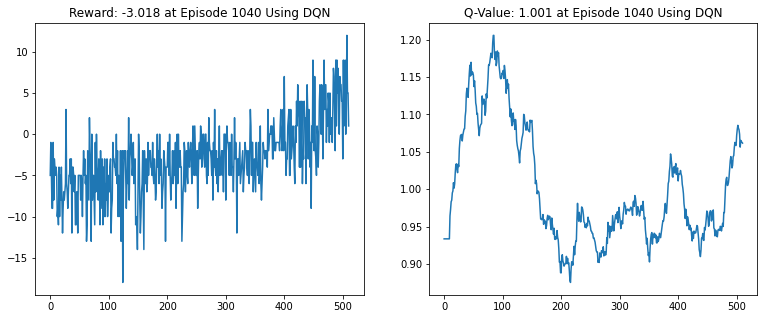

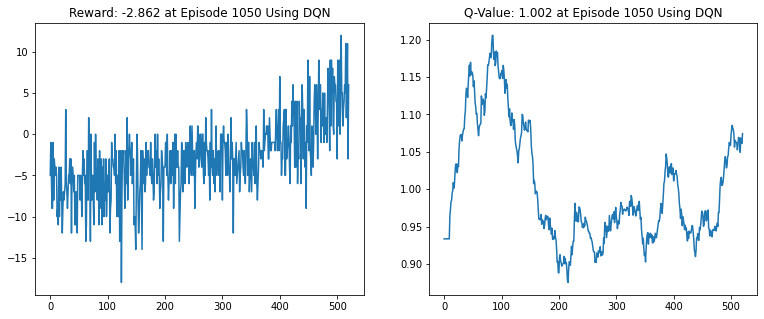

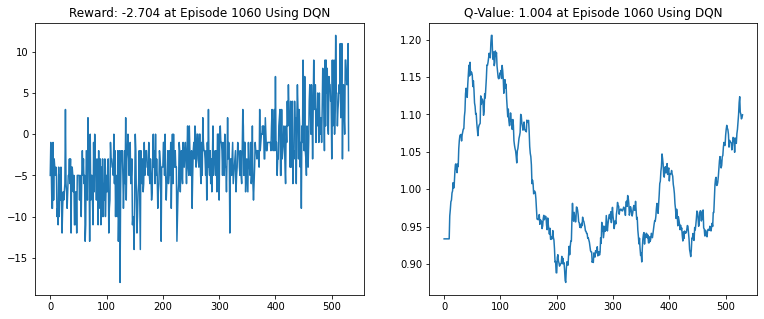

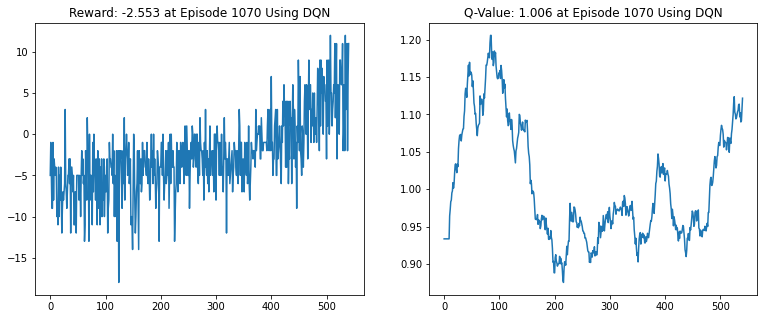

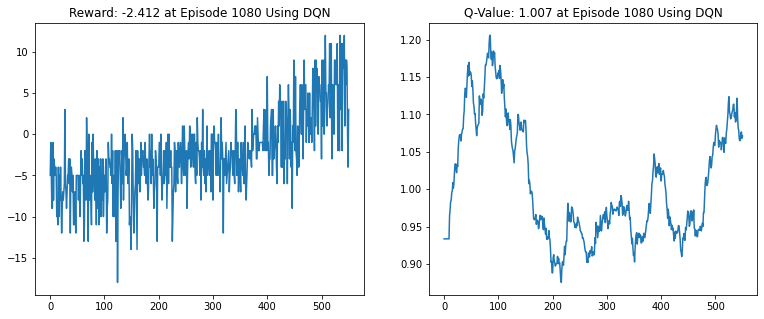

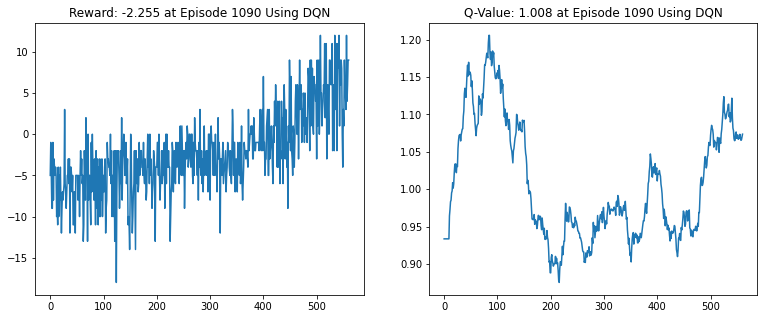

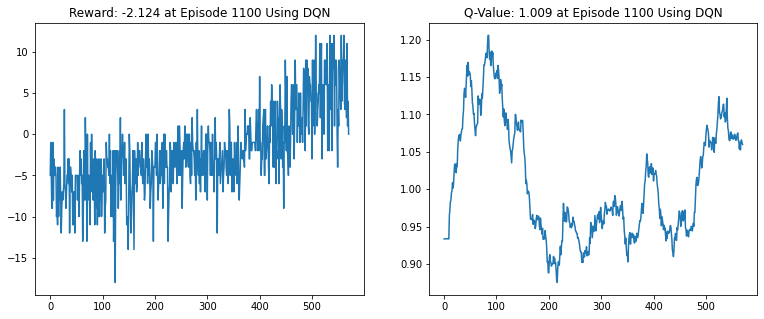

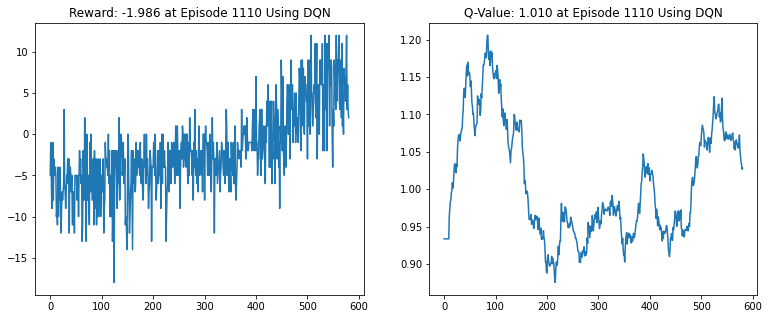

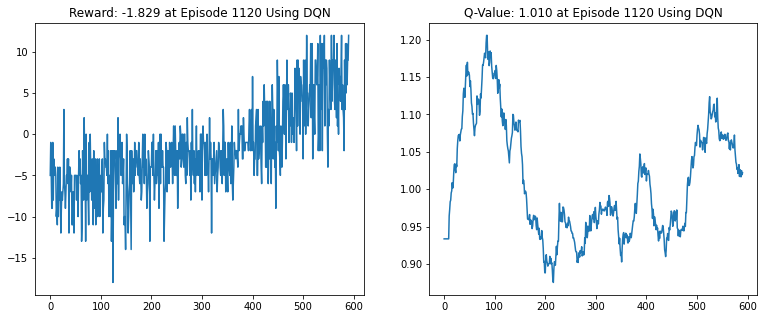

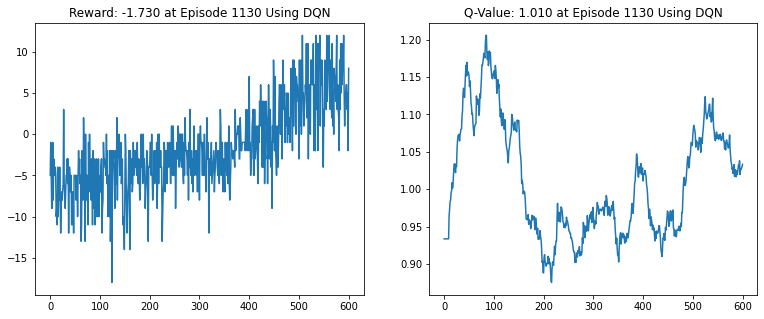

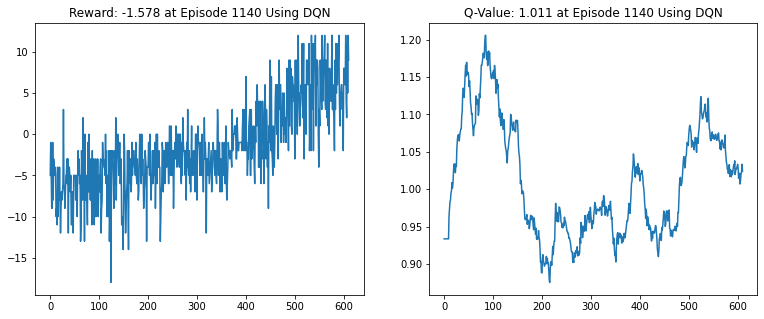

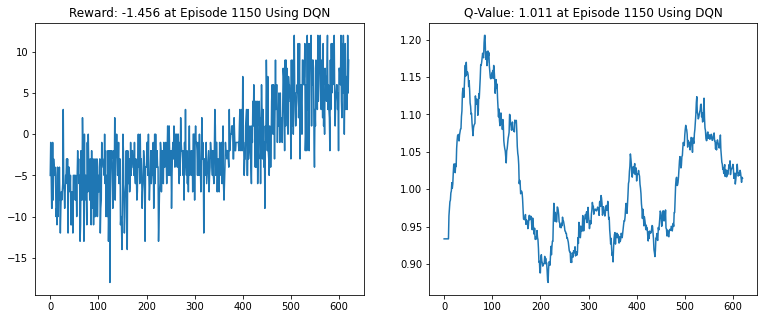

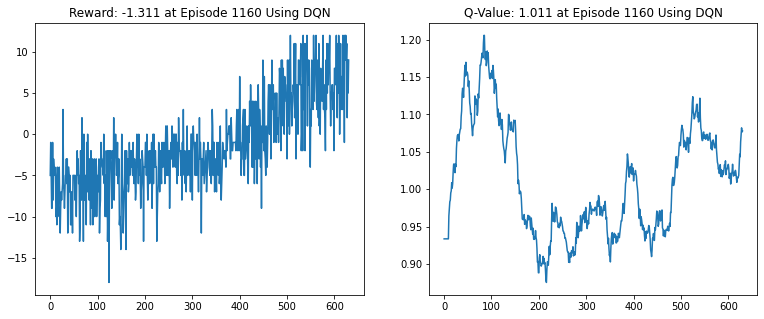

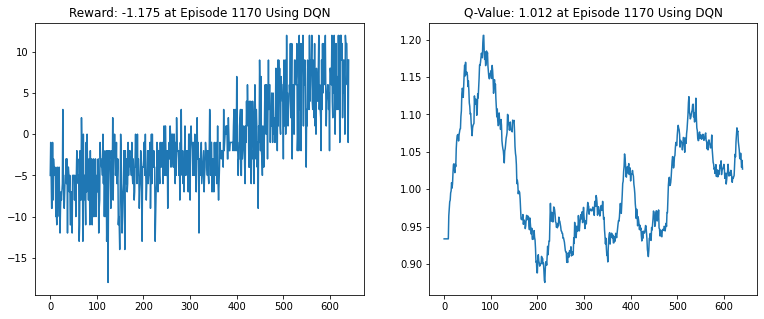

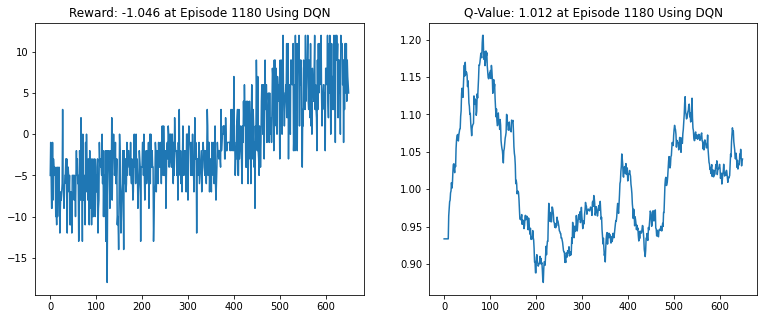

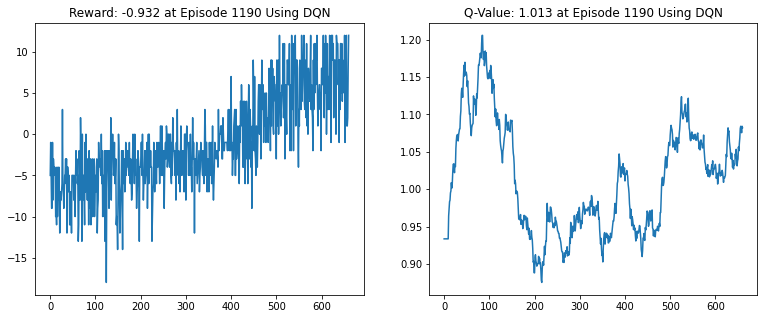

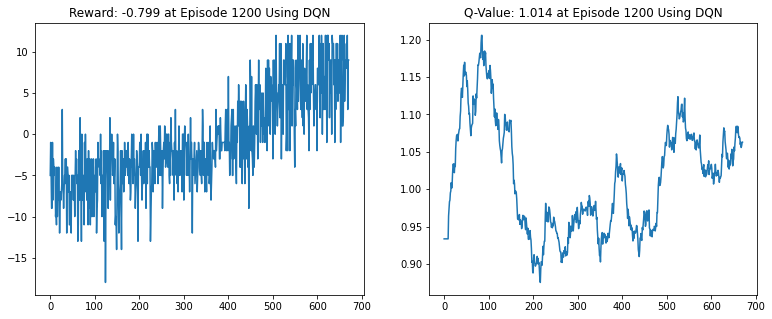

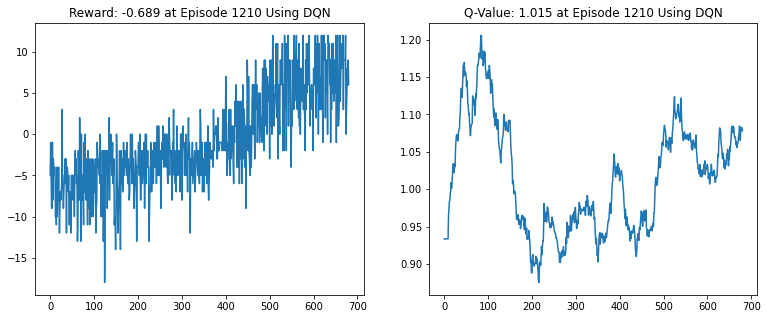

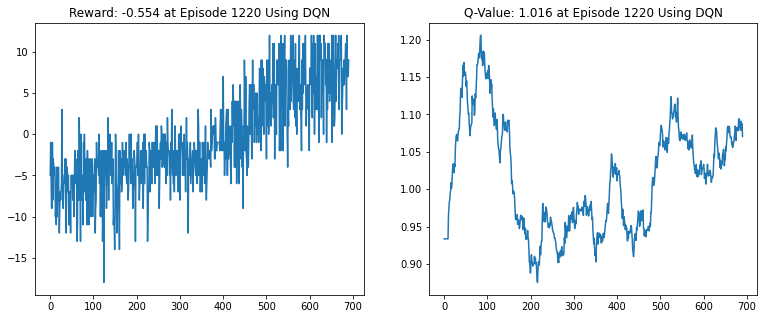

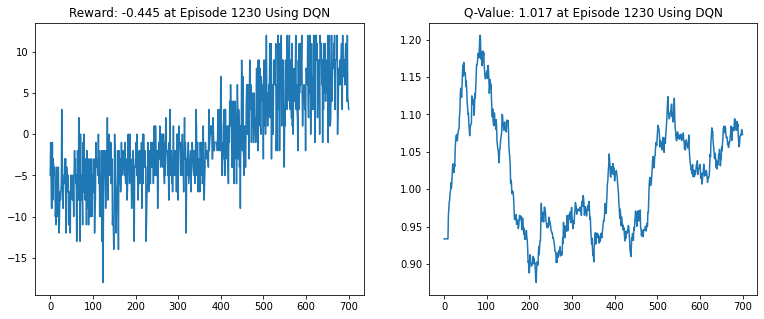

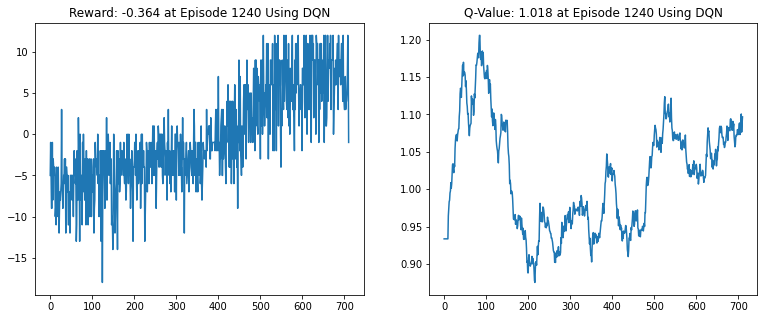

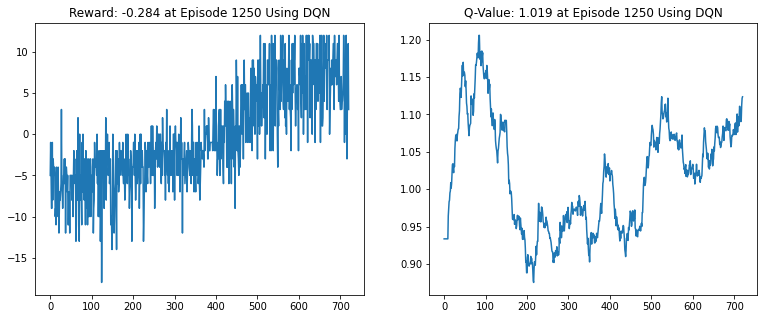

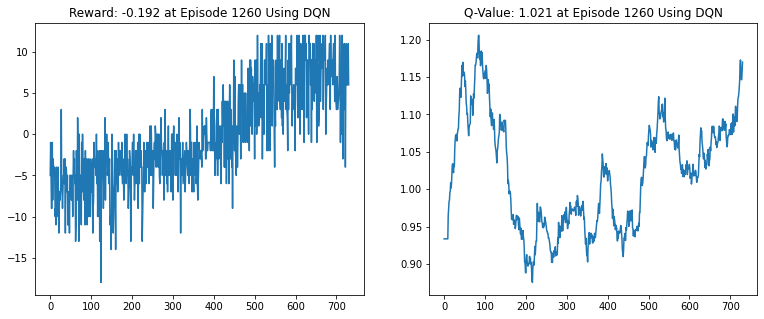

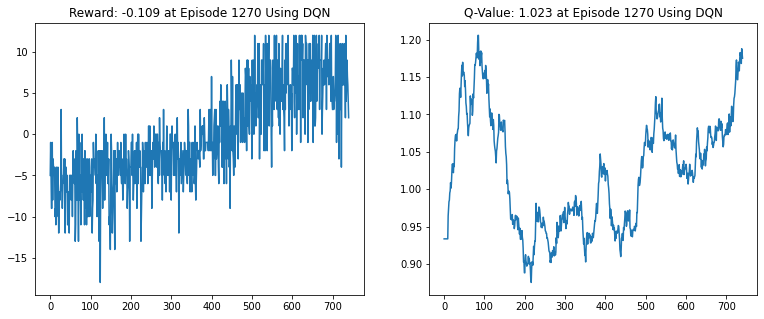

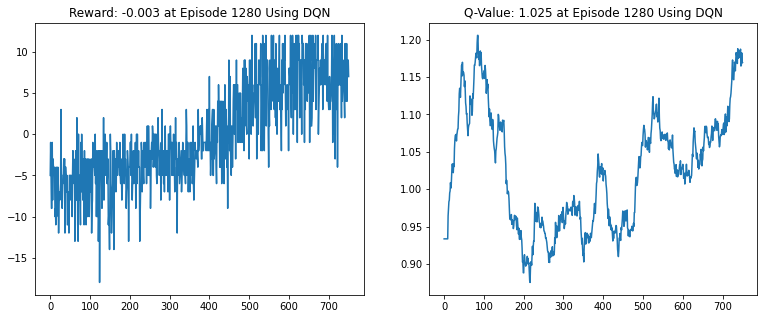

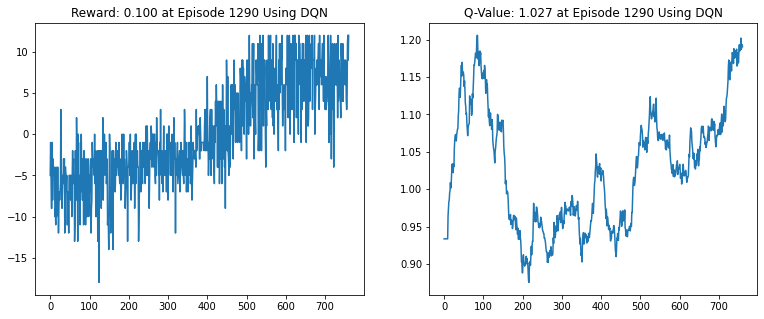

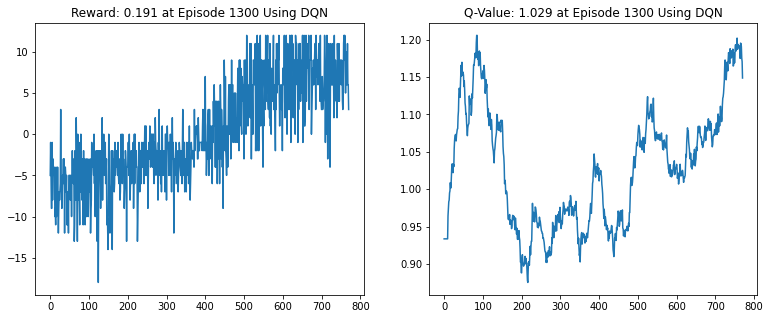

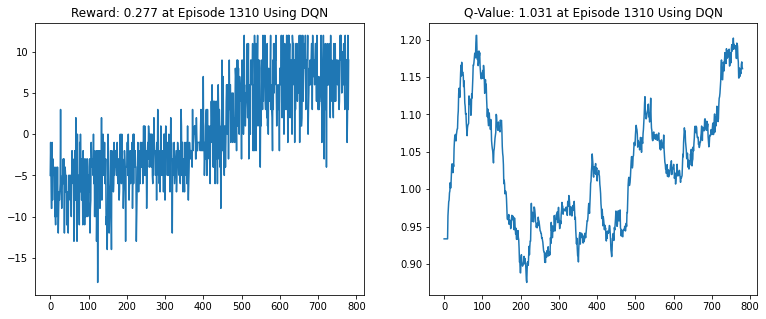

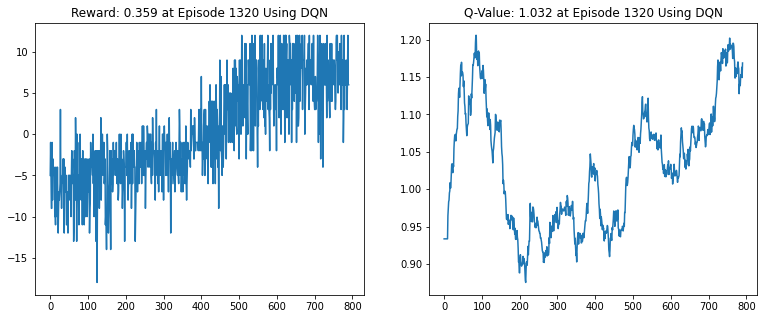

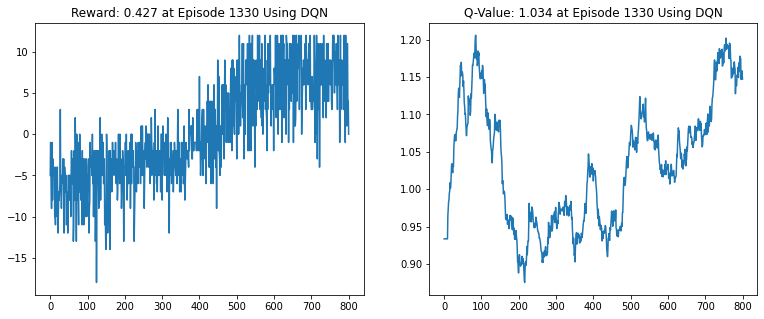

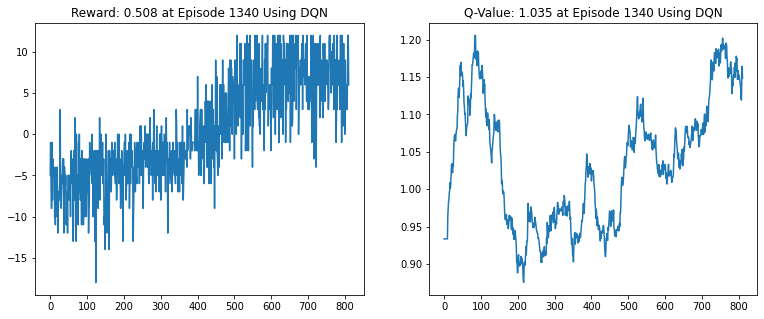

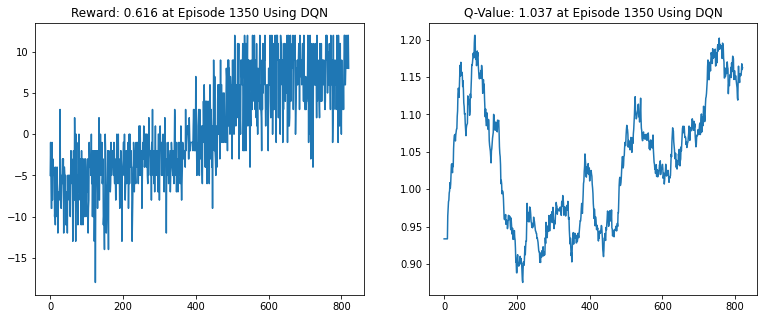

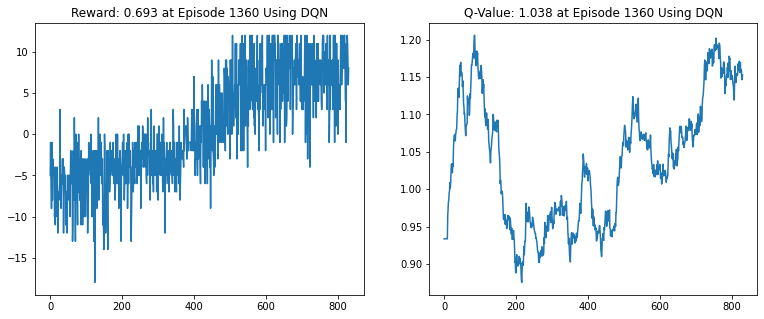

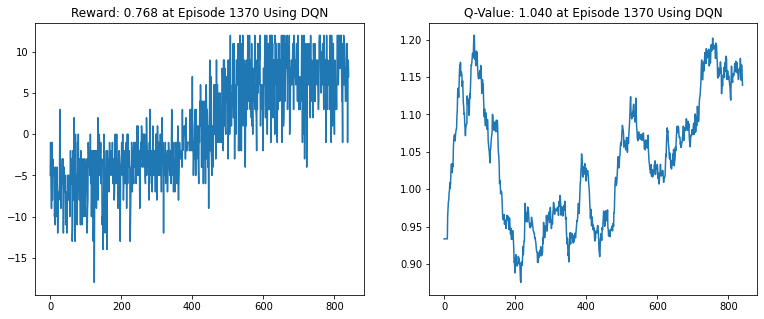

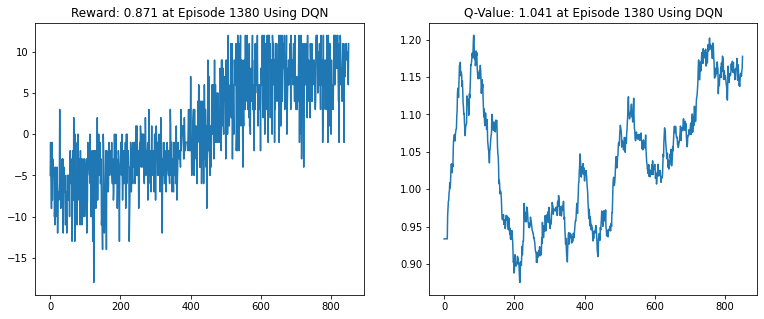

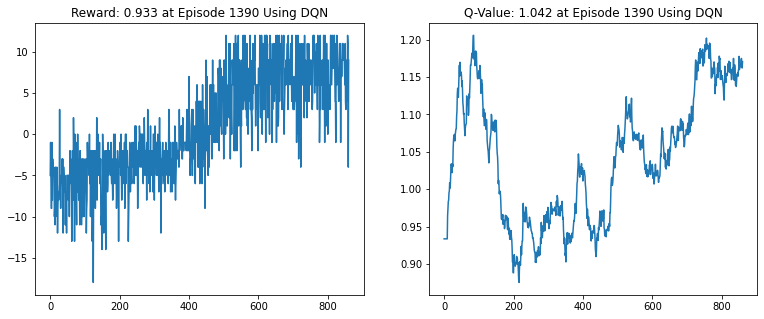

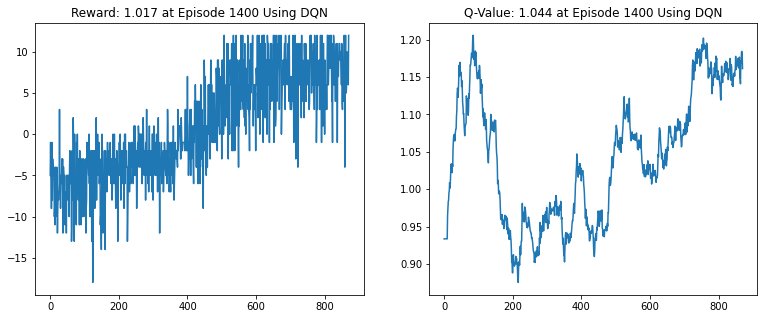

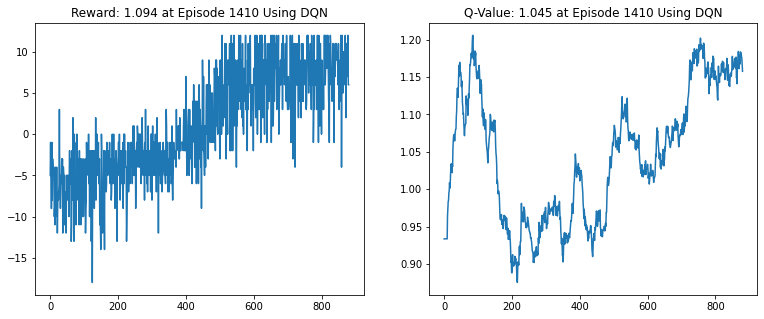

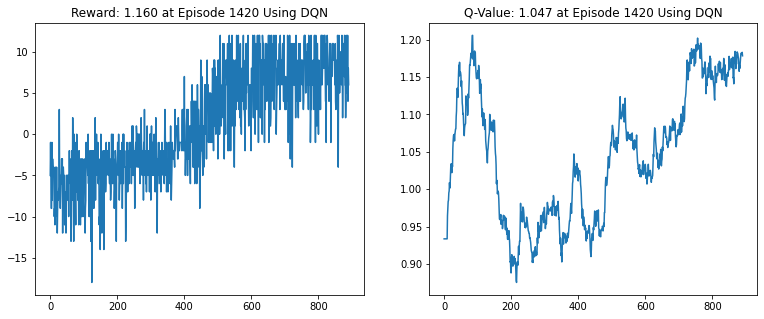

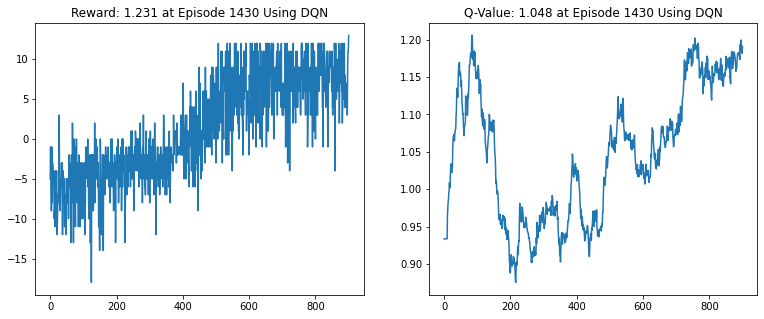

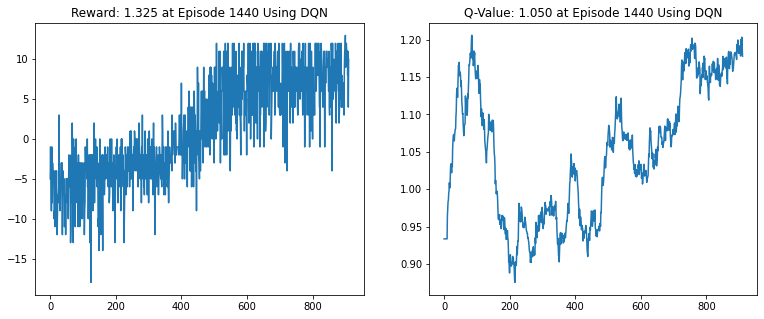

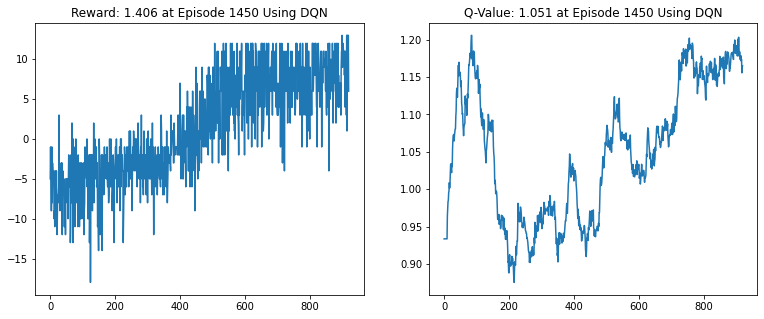

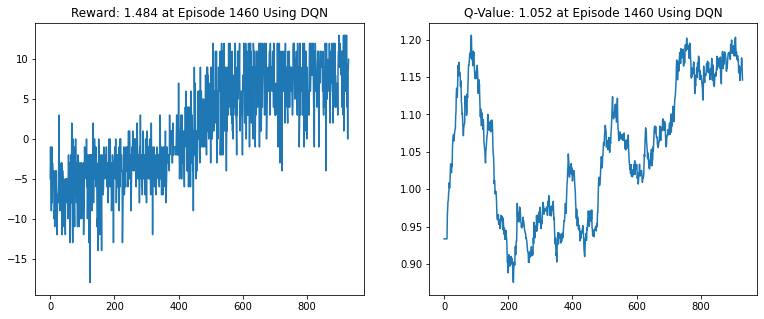

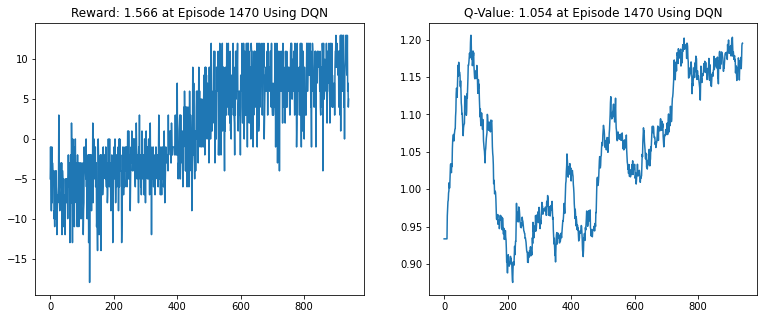

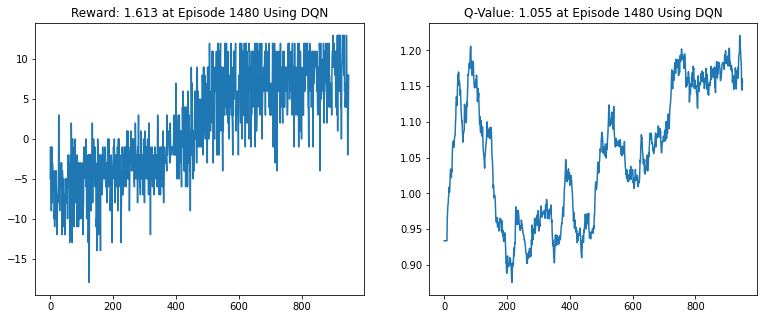

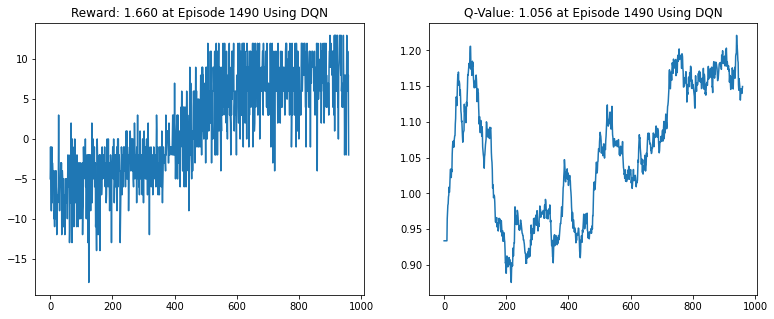

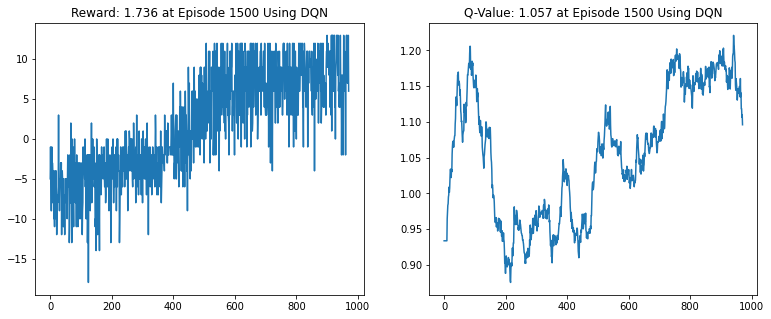

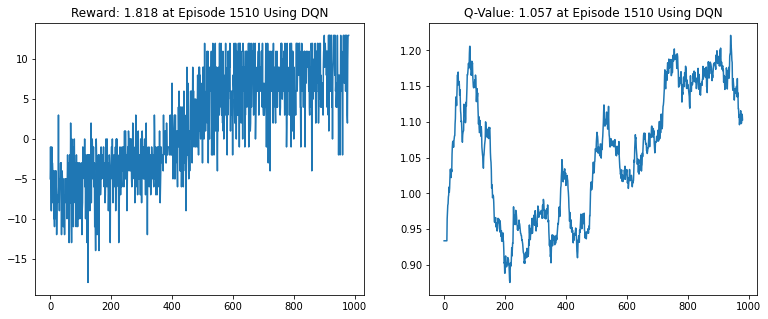

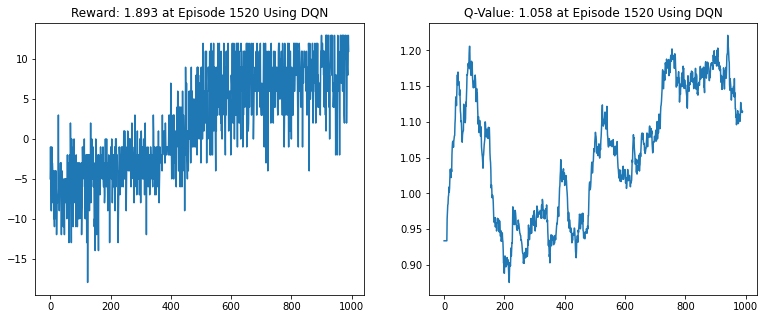

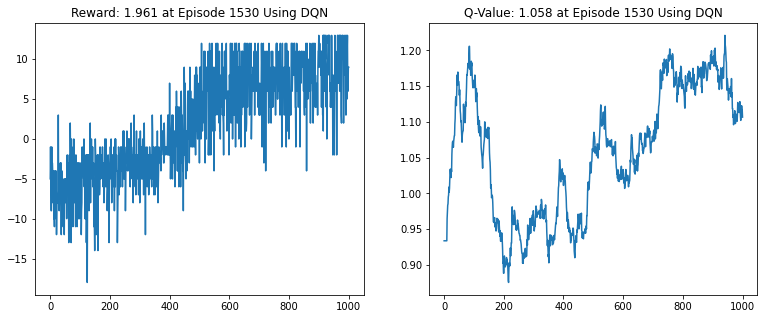

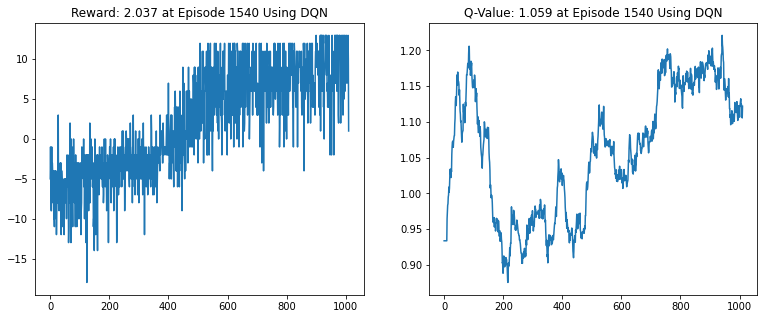

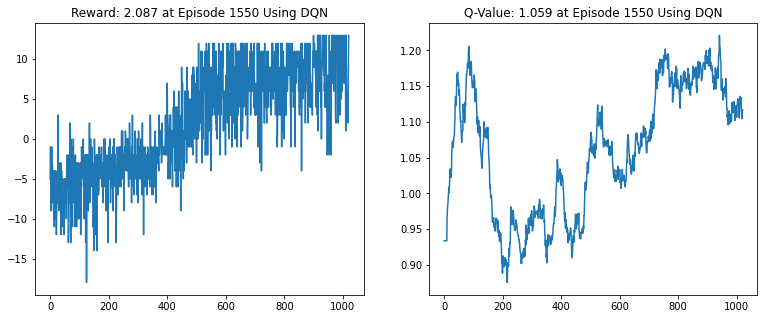

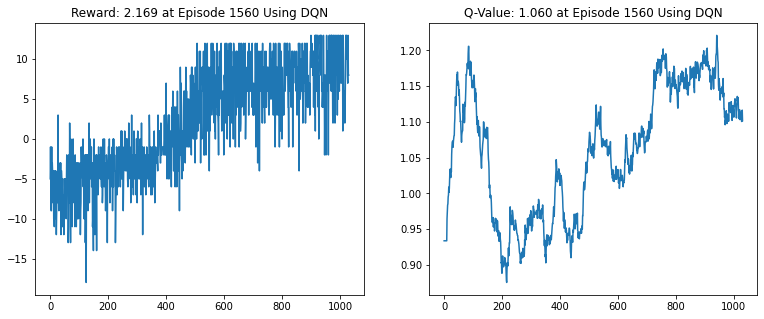

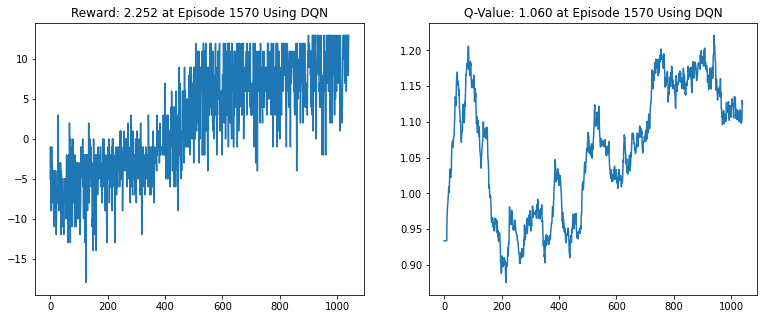

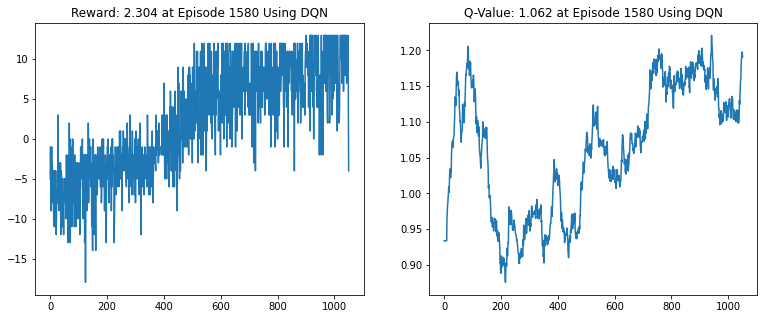

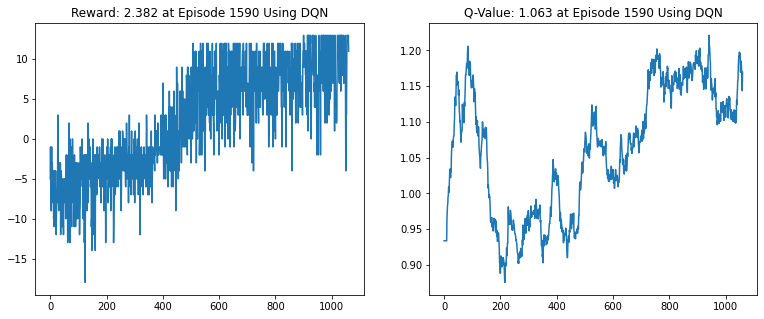

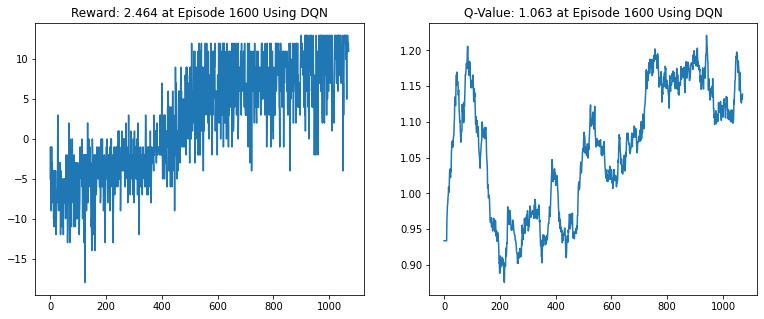

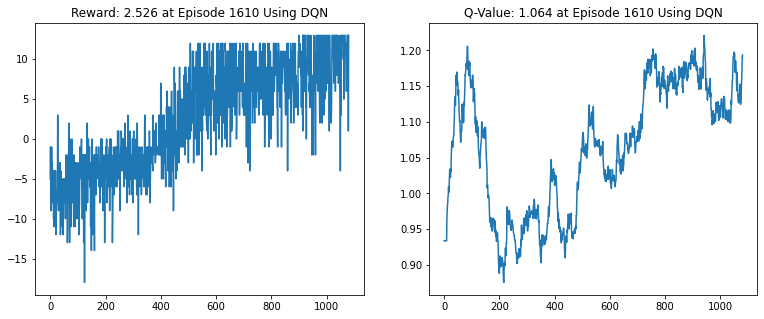

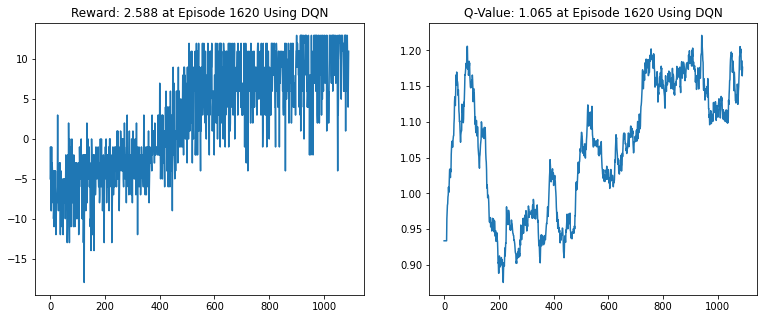

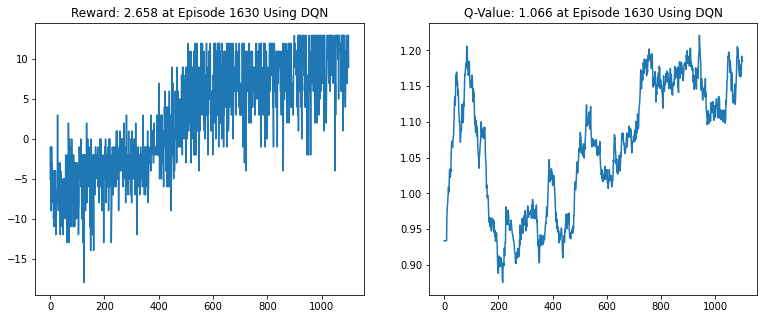

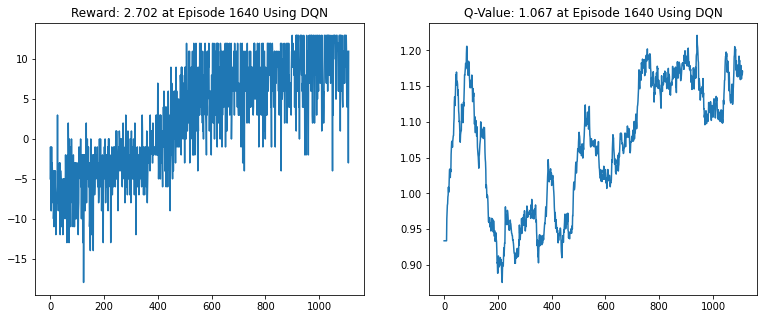

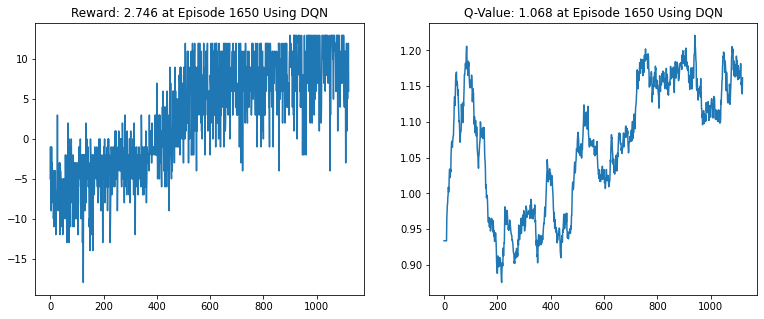

In [ ]:
network = AtariCNN(state_dim=4, action_dim=2).to(DEVICE)
target_network = AtariCNN(state_dim=4, action_dim=2).to(DEVICE)
optim = torch.optim.Adam(network.parameters(), lr=LR)
criterion = torch.nn.MSELoss()
buffer = ReplayBuffer(max_length=BUFFER_SIZE)
current_episode = 530

total_rewards, total_q_values = train(network, target_network, optim, criterion, buffer, current_episode)
print(f'REWARD: {np.mean(total_rewards)}')
print(f'Q-VALUE: {np.mean(total_q_values)}')

